# Plate recognition (HW)
![alt text](https://i.ytimg.com/vi/nmDiZGx5mqU/hqdefault.jpg)

**Deadline:** February 13th 23:55<br>
**Submission format:** .ipynb file with solution

In this homework you will try to recognize a Russian number plate. You can use any method for symbol recognition (CNN, some classic algorithm or Tesseract). But you are not allowed to use Tesseract for full number plate recognition, only use it to recognize single symbols! The main concept is:


1. Undistort the plate (you are given 4 corner points of the plate)
2. Perform segmentation
3. Recognize symbols
4. Concatenate recognized symbols

**Very important**: Your code needs to run! Hand in all files that are needed to run the code within a .zip-file and instructions to make it run! **Not running code parts will be awarded 0 points.**

**Plagiarism**, meaning identical code as in a different submission will lead to **0 points** for the whole submission! What is allowed is that you copy code if you use an existing model for recognizing the symbols - remember to reference to where you got the code from!

### Preparations

In [1]:
# Import libraries
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from IPython.display import clear_output
from matplotlib import pyplot as plt
# set inline plots size
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)
import numpy as np
import cv2

In [2]:
!wget "https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf" -O russian_plate_recog.jpg

img_gray = cv2.imread("russian_plate_recog.jpg", cv2.IMREAD_GRAYSCALE)
clear_output()

In [3]:
plate_points_1 = np.array([[1028, 874], [1184, 890], [1184, 924], [1027, 906]], np.int32)
plate_points_2 = np.array([[293, 714], [422, 719], [421, 749], [291, 743]], np.int32)

## Task 1: Draw borders around the number plate (10 points)

Draw the borders around the number plate and display the image with borders to visualize the region of interest! Try to get the tetragonal area as accurate as possible using the given plate points above! Also try to display colored borders on the otherwise greyscale image! Remember to draw on a copy of the image to leave the original image clean for the processing.

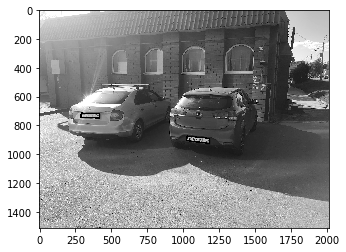

In [4]:
# TODO - add colors to the boarders
img_gray_copy = img_gray.copy()
cv2.polylines(img_gray_copy, plate_points_1.reshape((1, -1, 2)), True, color=(0, 255, 0) , thickness=8)
cv2.polylines(img_gray_copy, plate_points_2.reshape((1, -1, 2)), True, color=(0, 0, 255) , thickness=8)
plt.imshow(img_gray_copy, cmap='gray')

## Task 2: Undistort the plate (20 points)
Undistort the plate, so you receive an image that contains only the number plate. The OpenCV functions ```findHomography``` and ```warpPerspective``` might be helpful to get to the expected result!

Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1xNKKcR-KYeqfwLKAHmAdetsFRHL9VOHY)

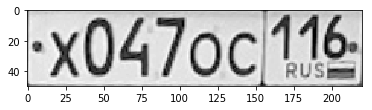

In [5]:
def undistort_the_plate(plate_points, img):
    sizes = np.array([[0, 0], [220, 0], [220, 50], [0, 50]])
    retval, mask = cv2.findHomography(plate_points, sizes)
    dst = cv2.warpPerspective(img, retval, (220,50))
    
    return dst


after_undistort = undistort_the_plate(plate_points_1, img_gray.copy())
plt.imshow(after_undistort, cmap='gray')

## Task 3: Segmentation (20 points)
Segment the symbols so that you can draw bounding rectangles around them. For example, you can use morphological operations, ```findContours```, and ```minAreaRect```. Draw only rectangles around the symbols that are relevant for recognition!


Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1nqP1g3VDctRfjBA6YV0A1OV3HF2FIEes)

In [6]:
def squares_around(img, thresh_val= 70):
    
#   for the first plate it may work without this deletions 
#   but for the second plate its much better with them
    img_copy = img.copy()
#  removes the block with 'rus' 
    img[34:,160:]= 255
#   removes the separate line between the number and the region code  
    img[:,150:158] = 255
#     removes edges' shadows
    img[:,:8] = 255
    img[:,210:] = 255
    img[:6, :] = 255
    img[46:,:] = 255

    ret,thresh = cv2.threshold(img,thresh_val,255,cv2.THRESH_BINARY)
    
    _,contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        rectangles.append((w*h,(x,y,x+w,y+h)))

#   we need to take out only 9 biggest by square rectangles as we have 9 symbols
#   we do not take the 1st as it return the rectangle aroung the whole image
    num_of_objects = 9
    rectangles = sorted(rectangles, key=lambda x: x[0], reverse=True)[1:10]

#   drawing rectangles in the image
    for i in rectangles:     
        x,y,w,h = i[1]
        cv2.rectangle(img_copy, (x,y), (w,h), (0, 255, 0), 1)
   
#   plot one under on as 1 image
    numpy_vertical_concat = np.concatenate((thresh, img_copy), axis=0)
    plt.imshow(numpy_vertical_concat, cmap='gray')
    plt.show()
    
    return img, rectangles

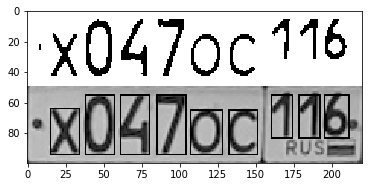

In [7]:
img, rectangles = squares_around(undistort_the_plate(plate_points_1, img_gray.copy()), thresh_val= 70)

## Task 4: Recognition (30 points)

Use any method/library to recognize the letters, of which you found the image regions in the previous step. For example, a CNN can help you to recognize letters. You can use any CNN model that you find on the internet, or even train your own. The EMNIST (Extended MNIST) dataset may be helpful. Remember to include files/instructions into the submission!

Symbols ```O``` and ```0``` are hard to distinct and will lead to no point reduction. Also ```1``` and ```7``` might be harder to distinguish and will only lead to a small reduction of points.

Expected result:

![alt text](https://drive.google.com/uc?export=view&id=1gb5xIGBTAadyqcrZzNC0I4VM3KAhjkF7)

In [123]:
# ! pip install emnist
# clear_output()

In [43]:
from emnist import extract_training_samples
from emnist import extract_test_samples
from sklearn.utils import shuffle 
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import pickle

* input shape is 28 x 28 
* letter label - the number of a letter in the english alphabet

In [9]:
# load dataset
train_digits, train_digits_labels   = extract_training_samples('digits')
train_letters, train_letters_labels = extract_training_samples('letters')

test_digits, test_digits_labels   = extract_test_samples('digits')
test_letters, test_letters_labels = extract_test_samples('letters')

# adding 9 to letters keys because labels for digits are [0,9],
# keys letters are [1,26], hence, they are intersecting 
test_letters_labels = test_letters_labels + 9
train_letters_labels= train_letters_labels + 9

In [28]:
# DATASET PREPROCESSING
# merging letters and digits
x_train = np.concatenate((train_digits, train_letters), axis =0)
y_train = np.concatenate((train_digits_labels, train_letters_labels), axis =0)
x_test  = np.concatenate((test_digits, test_letters), axis =0)
y_test  = np.concatenate((test_digits_labels, test_letters_labels), axis =0)

# shuffling letters and digits
x_train, y_train = shuffle(x_train, y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2] )
x_test, y_test = shuffle(x_test, y_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2] )

# binarizing train and test datasets to have the same distribution with our plate symbols
_, x_train_bin = cv2.threshold(x_train,110,255,cv2.THRESH_BINARY)
_, x_test_bin = cv2.threshold(x_test,110,255,cv2.THRESH_BINARY)

In [29]:
# SVC gives 2-3 percents better on the test dataset but takes much more time to train
# this will take about 7 minutes

# print(datetime.now())
# clf = RandomForestClassifier().fit(x_train_bin, y_train)
# print(datetime.now())
# print(clf.score(x_test_bin, y_test))
# print(datetime.now())

2020-09-04 16:45:14.331732
2020-09-04 16:50:04.907418
0.8794901315789474
2020-09-04 16:50:11.694815


In [46]:
# saving the trained model
# with open('trained.pkl', 'wb') as handle:
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
# uploading the saved model
f = open('trained.pkl', 'rb')
clf = pickle.load(f)
f.close()

In [22]:
def preprocess_plate_symbol(rectangle, image, th):
    x,y,w,h = rectangle[1]
#     resizing to emnist size -4 because of the frame to be added
    cur_symbol = 255-cv2.resize(image[y:h, x:w], (24,24))
    
    _, cur_symbol = cv2.threshold(cur_symbol,th,255,cv2.THRESH_BINARY)
    
#     in emnist dataset all symbols are centered and have 2 pixel frame
#   so we also add the frame to have the same distribution
    border = cv2.copyMakeBorder(
        cur_symbol,
        top=2,
        bottom=2,
        left=2,
        right=2,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    return border

In [30]:
predictions = []
numbers = undistort_the_plate(plate_points_1, img_gray.copy())
to_draw = []

for i in rectangles:
    border = preprocess_plate_symbol(i, numbers, th=110)
    #     this helps to distinguish between '4' and 'A'
    kernel = np.ones((3,3),np.uint8)
    border = cv2.erode(border, kernel,iterations = 1)
    pred = clf.predict(border.reshape(1, 28*28))
    to_draw.append(border)
    predictions.append(pred)

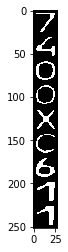

In [52]:
plt.imshow(np.array(to_draw).reshape(9*28, 28), cmap='gray')

## Task 5: Concatenation (5 points)
This should be the easiest part if you have done all previous steps:) Remember to get the order of symbols right!

Expected result: 
> **x0470c116**

In [32]:
def to_symbol(a):
    '''
    from label to symbol - 
    both letters and digits are returned as strings
    '''
    if a>=10:
        return chr(a+87)
    else:
        return str(a[0])
    
    
def find_the_order(rectangles, symbs):
    '''
    rectangles are sorted by area not by order
    this function sorted them by order 
    and returns predictions in the right order
    '''
    symbols =[to_symbol(i) for i in symbs]
    xs = [i[1][0] for i in rectangles]
    xs_copy = xs
    xs_copy = sorted(xs_copy, reverse=True)
    out = []
    for i in xs_copy:
        out.append(symbols[xs.index(i)])
    out.reverse()
    return out

In [33]:
print("".join(find_the_order(rectangles, predictions)))    

x0470c776


Unfortuantely, it is not able to distinguish 1 and 7s

## Task 6: Clean up your code (15 points)

Your code quality will be graded. You should clean up your code, try to make it readable and reusable. Only comment code parts that might need explaining, remove unnecessary comments and code parts that were only needed during development!

The required 15 points can be reached by basic cleaned-up, uncluttered code. Bonus points will be rewarded for encapsulating code into functions with meaningful parameters for reusability. This can also help you when trying to recognize the second number plate for more bonus points (see below!).

## Bonus task: Second Number Plate (15 bonus points)

Try to recognize the symbols in the second number plate! If the code for the first plate is not working well for the second plate, try to see, how to improve your code! The points will be rewarded depending on how much you need to change your code (is it generalizing well?) and how well the symbols have been recognized.

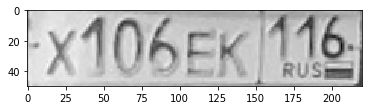

In [34]:
after_undistort2 = undistort_the_plate(plate_points_2, img_gray.copy())
plt.imshow(after_undistort2, cmap='gray')

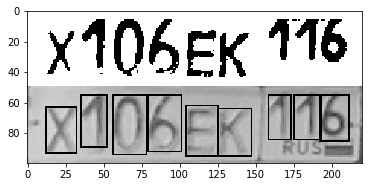

In [35]:
# with threshold = 166 the rectangles are more accurate
img2, rectangles2 = squares_around(after_undistort2.copy(), thresh_val= 166)

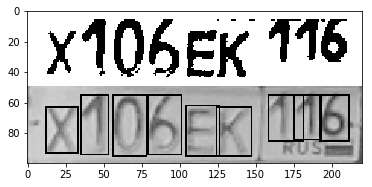

In [36]:
# but with  threshold = 170 the classification works better
img2, rectangles2 = squares_around(after_undistort2.copy(), thresh_val= 170)

In [40]:
predictions2 = []
numbers2 = undistort_the_plate(plate_points_2, img_gray.copy())
# numbers = dilation.copy()
to_draw2 = []

for i in rectangles2:  
    border = preprocess_plate_symbol(i, numbers2, th=95)
    pred = clf.predict(border.reshape(1, -1))
    to_draw2.append(border)
    predictions2.append(pred)

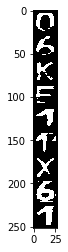

In [41]:
plt.imshow(np.array(to_draw2).reshape(9*28, 28), cmap='gray')

In [331]:
print("".join(find_the_order(rectangles2, predictions2)))    

x70g5k776


It should be *x106ek116*, however, it recognizes 1s as 7s as for the previous plate (2 symbols) and it recognizes 'x', '0', 'k' and last '6' correctly. Adding dilation before predictions may help to recognize 'e' but will remove last '6' and misclassify '7's to some other symbols, hence, the first version of code, without dilations is better. 